In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [33]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Models import TwoLevelSystems as TLS
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [4]:
# Update data from the ismhpc server. The command has to be executed directly from the command line, 
# actually os.system does not recognize the files to be excluded. 
# The --dry-run option can be used to control the effects
# of the command before the real copy
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*_CPU_*'} "
if dry_run: rsync_str += '--dry-run '
#ssh_str = '-e ssh ismhpc:/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_decay_time/PHOTON_ECO/RT_Echo_k509-activated-energy_1.46-width_0.025/ '
ssh_str = '-e ssh ismhpc:/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_decay_time/PHOTON_ECO/RT_Echo_k1000_kspan0.06/ '
#dest_path = 'RT_Echo_k509-activated-energy_1.46-width_0.025'
dest_path = 'RT_Echo_k1000_kspan0.06'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)
#os.system(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*_CPU_*'} -e ssh ismhpc:/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_decay_time/PHOTON_ECO/RT_Echo_k1000_kspan0.06/ '/home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/RT_Echo_k1000_kspan0.06'


In [3]:
omp = 1
mpi_k = 16
mpi_b = 1
mpi = int(mpi_k*mpi_b)
print('number of mpi',mpi)
sbatch_options = ['--partition=all12h'] #,'--ntasks-per-node=16']

number of mpi 16


In [4]:
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=sbatch_options)
code.global_options()

TypeError: __init__() missing 1 required positional argument: 'runRules'

In [38]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,executable='yambo_rt',activate_BeeOND=True) #,clean_restart=False,skip=False)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

We have performed some performance tests to find the optimal choice of the k_b parallelization.
Here the preliminary results

16_1 run is 1m-59s

16_2 run is 2m-36s

32_1 run is 4m-07s

32_1_2nodee does not create the BeeOND_Dir

# Echo signal from RT analysis in GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

## Analysis of the echo peak from the RT non-perturbative solution. Decay time determination and echo efficiency assessment 

We repeat the previous analysis using an improved k sampling in which an higher number of k points in the energy range of the pulses is used. 
In this way we test if a richer sampling reduce the non echo contribution due to an FID.

In this stage we also add an explicit decaying time on the coherences and use the echo signal to compute the decay time.

In [18]:
# Common parameters (eventually overwritten by the dictionary values)
time_step = 10 # as

# analysis with improved k-points sampling
#run_dir = 'RT_Echo_k509-activated-energy_1.46-width_0.025'
#source_dir = 'NSCF/bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025.save'

# analysis with k sampling volume of 0.06 (1000 points)     
run_dir = 'RT_Echo_k1000_kspan0.06'
source_dir = 'NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save'

We set the intensity of the pulses and time shift and we extract the echo signal from the non-perturbative solution

In [19]:
#int1, int2 = 1e3, 1e3 # intensity of the pulses in kW/cm^2
#int_str = 'int_1e3_1e3'

#int1, int2 = 1e4, 1e4 # intensity of the pulses in kW/cm^2
#int_str = 'int_1e4_1e4'
#int_str = 'int_1e4_1e4-bands_2-5'

#int1, int2 = 1e5, 1e5 # intensity of the pulses in kW/cm^2
#int_str = 'int_1e5_1e5'

#int1, int2 = 1e6, 1e6 # intensity of the pulses in kW/cm^2
#int_str = 'int_1e6_1e6'

int1, int2 = 1e7, 1e7 # intensity of the pulses in kW/cm^2
#int_str = 'int_1e7_1e7'
#int_str = 'int_1e7_1e7-bands_2-5'
int_str = 'int_1e7_1e7-bands_4-5'

#int1, int2 = 8254, 33015 # intensity of the pulses in kW/cm^2
#int_str = 'int_pi2_pi_extended-bands' # computations are performed with bands : [2,8]
#int_str = 'int_pi2_pi_extended-bands_tau-no-omega-multiple' # the tau is not a multiple of omega

#eta = 0.
#eta = 4e-4
eta = 4e-3

We set the number of RT_bands

In [20]:
RT_bands = [4,5] #[2,5] #[2,8]

In [21]:
fwhm = 10 #100 # fs FWHM of the pulses 
energy = 1.58 # 1.46 # eV energy of the pulse
#pulse_str='omega_1.46-fwhm_100'
#pulse_str='omega_1.58-fwhm_100'
pulse_str='omega_1.58-fwhm_10'
#pulse_str='omega_1.58-fwhm_10-tau_pulse_multiple'

omega = energy/h_red # angular frequency of the pulse
period = h/energy # period of the pulse fs
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
NETime = 600 #6000 # fs length of the simulation

In [22]:
np.exp(-eta*NETime)

0.09071795328941251

In [23]:
#tau = {'0.5ps':period*177,'1ps':period*353,'1.5ps':period*530,'2ps':period*706,'2.5ps':period*883}
#tau = {'0.5ps':500.,'1ps':1000.,'1.5ps':1500.,'2ps':2000.,'2.5ps':2500.}
#tau = {'50fs':50.,'100fs':100.,'150fs':150.,'200fs':200.,'250fs':250.}
tau = {'100fs':100.}
#tau = {'100fs':period*int(100/period)}
tau

{'100fs': 100.0}

In [24]:
simulations = []
simulations.append({ # add the ref simulation
    'source_dir' : source_dir,
    'id' : ('ref',int_str,pulse_str),
    'run_dir' : run_dir,
    'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear')],
    'sim_time'  : NETime,
    'eta'       : 1e-5,
    'no_sym'    : False,
    'bands'     : RT_bands,
    'skip'      : True
    }
)
for t in tau: # add the simulations for each value of tau
    simulations.append({
        'id' : (t,'direct',int_str,pulse_str),
        'source_dir' : source_dir,
        'run_dir' : run_dir,
        'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=int2,freq=energy,fwhm=fwhm,polarization='linear',tstart=tau[t],tstart_units='fs')],
        'sim_time'  : NETime,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'bands'     : RT_bands,
        'skip'      : True
    })
    simulations.append({
        'id' : (t,'invert',int_str,pulse_str),
        'source_dir' : source_dir,
        'run_dir' : run_dir,
        'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=int2,freq=energy,fwhm=fwhm,polarization='linear',
                     direction=[-1.,0.,0.],tstart=tau[t],tstart_units='fs')],
        'sim_time'  : NETime,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'bands'     : RT_bands,
        'skip'      : True
    })

In [25]:
simulations[1]

{'id': ('100fs', 'direct', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10'),
 'source_dir': 'NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save',
 'run_dir': 'RT_Echo_k1000_kspan0.06',
 'fields': [{'index': 1,
   'int': 10000000.0,
   'freq': 1.58,
   'fwhm': 10,
   'polarization': 'linear'},
  {'index': 2,
   'int': 10000000.0,
   'freq': 1.58,
   'fwhm': 10,
   'polarization': 'linear',
   'tstart': 100.0,
   'tstart_units': 'fs'}],
 'sim_time': 600,
 'eta': 1e-05,
 'no_sym': False,
 'bands': [4, 5],
 'skip': True}

### Construction of the SAVE folder and FixSymm procedure

In [26]:
#for ind,sim in enumerate(simulations):
for sim in simulations:
    source_dir = sim['source_dir']
    run_dir = sim['run_dir']
    if not sim['no_sym']:
        sim['rt_run_dir'] = os.path.join(sim['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%str(sim['id']))
        Tools.build_SAVE(source_dir,run_dir,make_link=True,overwrite_if_found=False)
        Tools.make_FixSymm(run_dir,Efield1=[1.,0.,0.],overwrite_if_found=False)
    else:
        sim['rt_run_dir'] = sim['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim['id'])
        Tools.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for sim in simulations:
    rt_run_dir = sim['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    #print(command)
    os.system(command)

build SAVE and perform FixSymm for ('ref', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10')
SAVE folder already present in RT_Echo_k1000_kspan0.06. No operations performed.
SAVE folder already present in RT_Echo_k1000_kspan0.06/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for ('100fs', 'direct', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10')
SAVE folder already present in RT_Echo_k1000_kspan0.06. No operations performed.
SAVE folder already present in RT_Echo_k1000_kspan0.06/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for ('100fs', 'invert', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10')
SAVE folder already present in RT_Echo_k1000_kspan0.06. No operations performed.
SAVE folder already present in RT_Echo_k1000_kspan0.06/FixSymm. No operations performed.
 


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [27]:
io_time = [10.0,10.0,0.1] # [5.0,1.0,1.0] # I/O (CARRIERs - GF - OUTPUT) in fs FOR THE 10 fs FWHM SIMULATIONS
#io_time = [50.0,50.0,1.0] # [5.0,1.0,1.0] # I/O (CARRIERs - GF - OUTPUT) in fs
#io_cacheTime = [[50.0,100.0],'fs'] # Time between two consecutive (caching - I/O) of OBSERVABLES
io_cacheTime = [[0.1,10.0],'fs'] # Time between two consecutive (caching - I/O) of OBSERVABLES

In [28]:
simulations[0]

{'source_dir': 'NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save',
 'id': ('ref', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10'),
 'run_dir': 'RT_Echo_k1000_kspan0.06',
 'fields': [{'index': 1,
   'int': 10000000.0,
   'freq': 1.58,
   'fwhm': 10,
   'polarization': 'linear'}],
 'sim_time': 600,
 'eta': 1e-05,
 'no_sym': False,
 'bands': [4, 5],
 'skip': True,
 'rt_run_dir': 'RT_Echo_k1000_kspan0.06/FixSymm'}

In [30]:
for sim in simulations:
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=sim['rt_run_dir'])
    for f in sim['fields']:
        rt_input.set_rt_field(**f)
    if eta == 0.:
        rt_input.set_rt_bands(bands=sim['bands'],scissor=scissor,damping_valence=sim['eta'],damping_conduction=sim['eta'])
    else:
        rt_input.set_rt_bands(bands=sim['bands'],scissor=scissor,damping_valence=0.,damping_conduction=0.)
        rt_input['variables']['PhLifeTime'] = [1/eta,'fs']
    rt_input.set_rt_simulationTimes(sim_time=sim['sim_time'],io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(k=mpi_k,b=mpi_b)
    #rt_input['variables']['DBsIOoff']='obs carriers'  # do not write these databases on file
    rt_input['variables']['DBsIOoff']='obs'  # do not write these databases on file
    rt_input['variables']['IOCachetime'] = io_cacheTime
    #rt_input['arguments'].append('SaveGhistory')
    sim['input'] = rt_input

In [31]:
#simulations[1]

In [45]:
study = D.Dataset(num_tasks=3)
study.set_postprocessing_function(PP.yambo_parse_data)

for sim in simulations:
    #study.append_run(id=sim['id'],input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])
    study.append_run(id=sim['id'],input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=False)

Initialize a Dataset with 3 parallel tasks


In [46]:
study.ids

[('ref', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10'),
 ('100fs', 'direct', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10'),
 ('100fs', 'invert', 'int_1e7_1e7-bands_4-5', 'omega_1.58-fwhm_10')]

In [47]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
delete job_out script: RT_Echo_k1000_kspan0.06/FixSymm/job_100fs-invert-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10.out
delete folder: RT_Echo_k1000_kspan0.06/FixSymm/100fs-invert-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10
run command: mpirun -np 16 yambo_rt -F 100fs-invert-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10.in -J 100fs-invert-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10 -C 100fs-invert-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10
delete job_out script:slurm submit: delete job_out script:   cd RT_Echo_k1000_kspan0.06/FixSymm ; sbatch job_100fs-invert-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10.shRT_Echo_k1000_kspan0.06/FixSymm/job_ref-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10.outRT_Echo_k1000_kspan0.06/FixSymm/job_100fs-direct-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10.out


computation 100fs-invert-int_1e7_1e7-bands_4-5-omega_1.58-fwhm_10 is running...delete folder:delete folder:
  RT_Echo_k1000_kspan0.

0.512076235
1.08595452
0.508195355


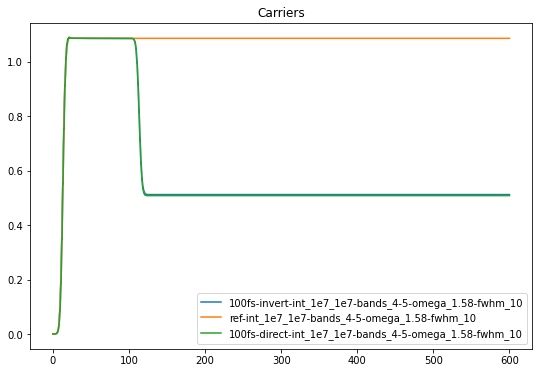

In [48]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    time = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    print(dne[-1])
    plt.plot(time,dne,label=D.name_from_id(study.ids[ind]))
plt.title('Carriers')
plt.legend(loc='best')

In [ ]:
for ind,r in results.items():
    plt.figure(figsize=(10,6))
    time = r.data['external_field']['time']
    profile = r.data['external_field']['Profile'] #['Ex_Re']
    plt.plot(time,profile,label=D.name_from_id(study.ids[ind]))
    plt.title('Field profile')
    plt.legend()

In [ ]:
for ind,r in results.items():
    plt.figure(figsize=(10,6))
    time = r.data['polarization']['time']
    dne = r.data['polarization']['Pol_x']
    plt.plot(time,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Polarization x component')
    plt.legend()

### Extraction of the echo signal

In [50]:
x_dipole = results[0].dipoles.r_dipole(0)

In [51]:
dft = results[0].dft
lat_vol = dft.eval_lattice_volume()
lat_vol

294.0614899039999

We compute the echo signal from the observable polarization

In [52]:
px_ref = results[0].data['polarization']['Pol_x']
#px_ref = results[0].data['current']['col1']
time = results[0].data['polarization']['time']

In [53]:
echo = {}

In [54]:
for t in tau:
    px =  []
    for val in ['direct','invert']:
        #ind = study.ids.index((t,val,eta_str,int_str))
        ind = study.ids.index((t,val,int_str,pulse_str))
        px.append(results[ind].data['polarization']['Pol_x'])
        #px.append(results[ind].data['current']['col1'])
    echo[t] = 0.5*(px[0]+px[1])-px_ref

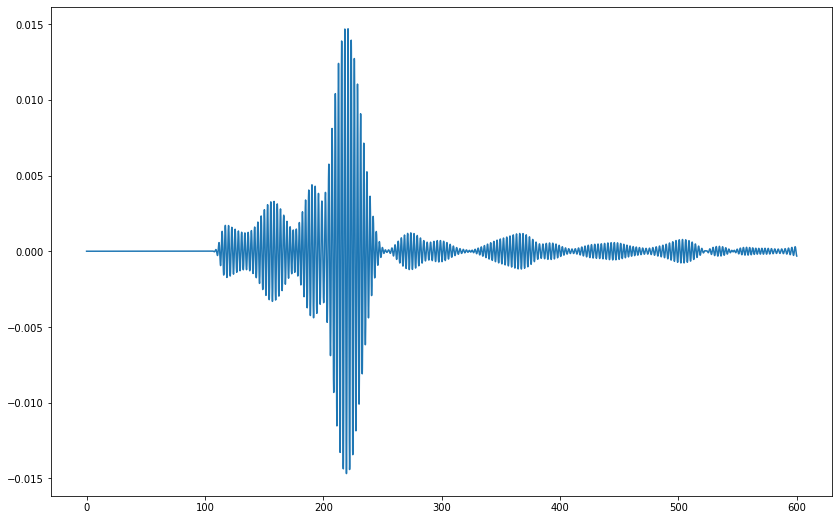

In [55]:
plt.figure(figsize=(14,9))
for t in tau:
    plt.plot(time,echo[t])
#plt.xlim(4000,4200)

We save relevant data on file

In [56]:
out = {}
out['time'] = time.tolist()
out['px_ref'] = px_ref.tolist()
out['echo'] = {}
out['profile'] = {}
for tau,val in echo.items():
    out['echo'][tau] = val.tolist()
    ind = study.ids.index((tau,'direct',int_str,pulse_str))
    profile = results[ind].data['external_field']['Profile']
    out['profile'][tau] = profile.tolist()

In [58]:
file_name = 'echo_%s_%s.yaml'%(int_str,pulse_str)
file = os.path.join(run_dir,'FixSymm','Results',file_name)
print('save on file %s'%file)
with open(file, 'w') as f:
    yaml.dump(out,f,default_flow_style=False)    

save on file RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e7_1e7-bands_4-5_omega_1.58-fwhm_10.yaml


And we can read data from file

In [67]:
file_name = 'echo_%s_%s_%s.yaml'%(eta_str,int_str,pulse_str)
file = os.path.join(run_dir,'FixSymm','Results',file_name)
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [69]:
time = data_loaded['time']
px_ref = data_loaded['px_ref']
echo = data_loaded['echo']
profile = data_loaded['profile']

In [70]:
profile.keys()

dict_keys(['0.5ps', '1.5ps', '1ps', '2.5ps', '2ps'])

## Build the (non-linear) $\eps$ with ypp_rt

In [12]:
run_dir_rt = 'RT_Echo_k1000_kspan0.06/FixSymm/'
name = 'ref-int_1e7_1e7-omega_1.58-fwhm_10/'
jobname = 'job_'+name

In [4]:
input = I.YamboInput('ypp_rt -rtplot X',folder=run_dir_rt)
input

{'args': 'ypp_rt -rtplot X',
 'folder': 'RT_Echo_k1000_kspan0.06/FixSymm/',
 'filename': 'yambo.in',
 'arguments': ['RT_X', 'RTtime'],
 'variables': {'Xorder': [1.0, ''],
  'ETStpsRt': [200.0, ''],
  'DampFactor': [0.0, 'eV'],
  'DampMode': 'NONE',
  'EnRngeRt': [[0.0, 20.0], 'eV'],
  'TimeRange': [['-1.000000', '-1.000000'], 'fs']}}

In [5]:
code = C.YamboCalculator(omp=1,mpi=1,executable='ypp_rt')

Initialize a Yambo calculator with scheduler direct


In [6]:
code?

Type:        YamboCalculator
String form: <mppi.Calculators.YamboCalculator.YamboCalculator object at 0x7f86544fd048>
File:        ~/Applications/MPPI/mppi/Calculators/YamboCalculator.py
Docstring:  
Perform a Yambo calculation. Computations are managed by a scheduler that,
in the actual implementation of the class, can be `direct` or `slurm`.


Parameters:
   omp (:py:class:`int`) : value of the OMP_NUM_THREADS variable
   mpi (:py:class:`int`) : number of mpi processes
   mpi_run (:py:class:`string`) : command for the execution of mpirun, e.g. 'mpirun -np' or 'mpiexec -np'
   executable (:py:class:`string`) : set the executable (yambo, ypp, yambo_rt, ...) of the Yambo package
   scheduler (:py:class:`string`) : choose the scheduler used to submit the job, actually the choices implemented are
        'direct' that runs the computation using the python subprocess package and 'slurm' that creates a slurm script
   skip (:py:class:`bool`) : if True evaluate if the computation can be skip

In [14]:
code.run(input=input,run_dir=run_dir_rt,name=name) #,jobname=jobname)

Skip the run of ref-int_1e7_1e7-omega_1.58-fwhm_10/


{'output': ['RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/o-ref-int_1e7_1e7-omega_1.58-fwhm_10.current',
  'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/o-ref-int_1e7_1e7-omega_1.58-fwhm_10.polarization',
  'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/o-ref-int_1e7_1e7-omega_1.58-fwhm_10.carriers',
  'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/o-ref-int_1e7_1e7-omega_1.58-fwhm_10.external_field'],
 'report': 'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/r-ref-int_1e7_1e7-omega_1.58-fwhm_10_negf',
 'dft': 'RT_Echo_k1000_kspan0.06/FixSymm/SAVE/ns.db1',
 'RT_G': 'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/ndb.RT_G',
 'RT_G_PAR': 'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/ndb.RT_G_PAR',
 'RT_carriers': 'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e7_1e7-omega_1.58-fwhm_10/ndb.RT_carriers',
 'RT_reference_components': 'RT_Echo_k1000_k